In [7]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

In [8]:
seq_ori = np.load("original.npy")

In [9]:
zt_freqs = cp.linspace(-90e3, 30e3, 1000)
zt_rabi = 4.2e3
zt_pulse = 500e-6
print(zt_rabi * zt_pulse)

2.1


In [10]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(1_000, temp)
frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry:   0%|          | 0/1000 [00:00<?, ?it/s]

Raman thermometry: 100%|██████████| 1000/1000 [00:15<00:00, 66.59it/s]


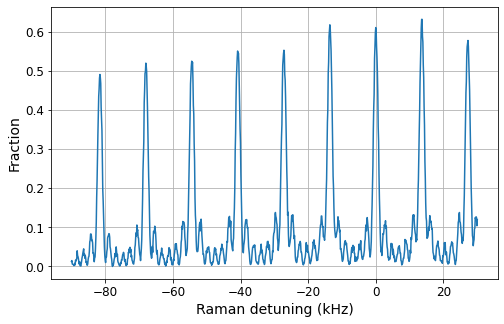

In [11]:
plt.figure(figsize=(8,5))
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations)/1000)
plt.xlabel("Raman detuning (kHz)", fontsize=14)
plt.ylabel("Fraction", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

Raman pulses: 100%|██████████| 280/280 [00:34<00:00,  8.22it/s]


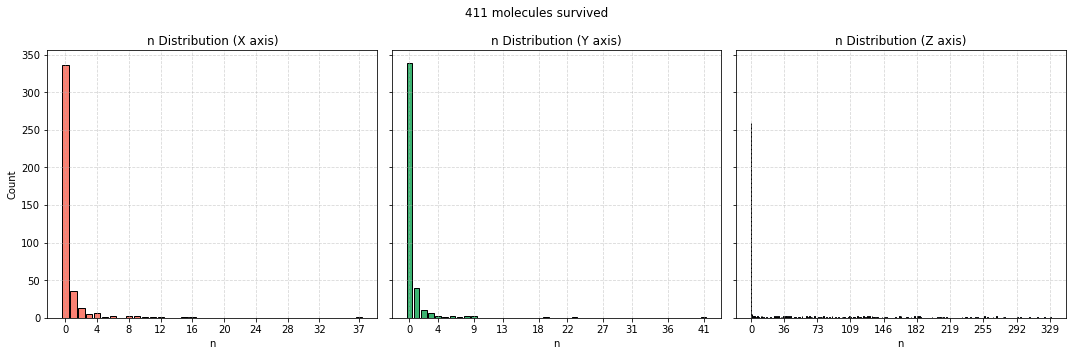

survival_rate_mean 0.411
mot_mean [ 0.63990268  0.59367397 41.11922141]
mot_sem [0.00398887 0.00430486 0.12139832]
Ground state rate 0.273784355179704


In [12]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(1_000, temp)
cr.raman_cool_with_pumping(
    mol_0, 
    seq_ori, 
    res, 
    show_progress=True, 
    Detuning=(0, 0, 0),
    k_max=0,)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=10)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])
print("Ground state rate", result['ground_state_rate_mean'])

In [13]:
frequencys, polarizations_2 = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry: 100%|██████████| 1000/1000 [00:15<00:00, 66.49it/s]


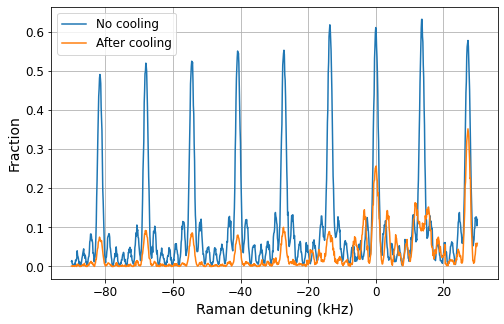

: 

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations)/1000, label="No cooling")
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations_2)/1000, label="After cooling")
plt.legend(fontsize=12)
plt.xlabel("Raman detuning (kHz)", fontsize=14)
plt.ylabel("Fraction", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

### Cold sample

In [13]:
temp = [0.1e-6, 0.1e-6, 0.1e-6]
mol_0 = cr.build_thermal_molecules_gpu(1_000, temp)
frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
)

Raman thermometry: 100%|██████████| 1000/1000 [00:14<00:00, 70.52it/s]


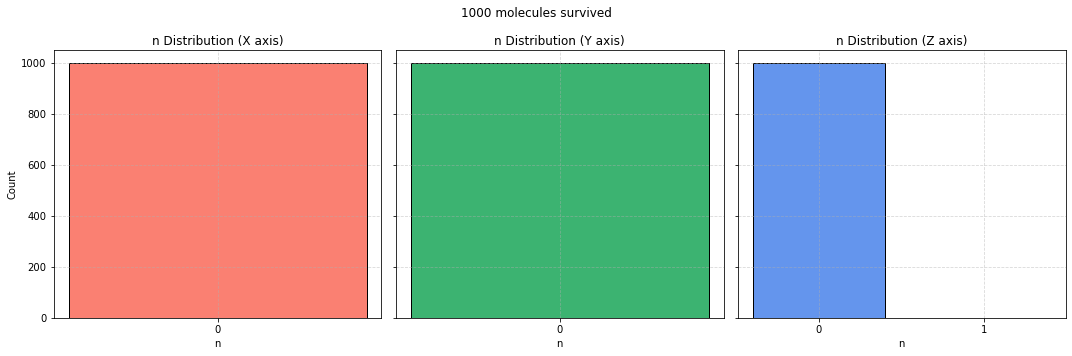

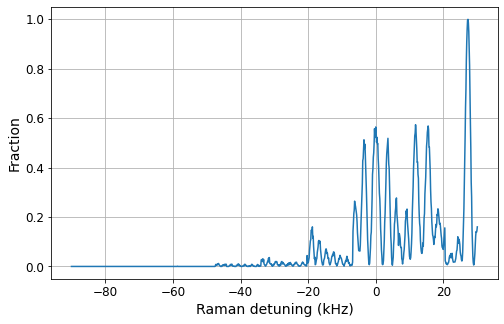

In [21]:
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=10)

plt.figure(figsize=(8,5))
plt.plot(cp.asnumpy(frequencys*1e-3), cp.asnumpy(polarizations)/1000)
plt.xlabel("Raman detuning (kHz)", fontsize=14)
plt.ylabel("Fraction", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid()

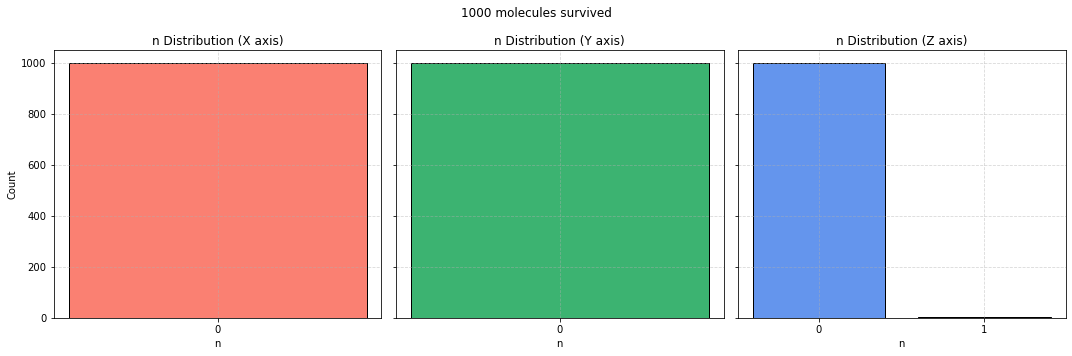

In [19]:
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=10)


Raman thermometry: 100%|██████████| 1000/1000 [00:13<00:00, 71.53it/s]


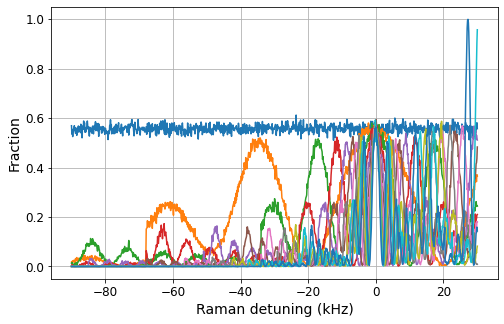

In [ ]:
pols = []
fractions = np.linspace(0, 1, 11)
for frac in fractions:
    frequencys, polarizations = cr.raman_sideband_thermometry(
    molecules_dev=mol_0,
    axis=2,
    frequencys=frac*zt_freqs,
    rabi_freq=zt_rabi,
    pulse_time=zt_pulse,
    res=res,
    k_max=2
    )
    pols.append(cp.asnumpy(polarizations))
pols = np.array(pols)


In [24]:
np.arange(len(fractions))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

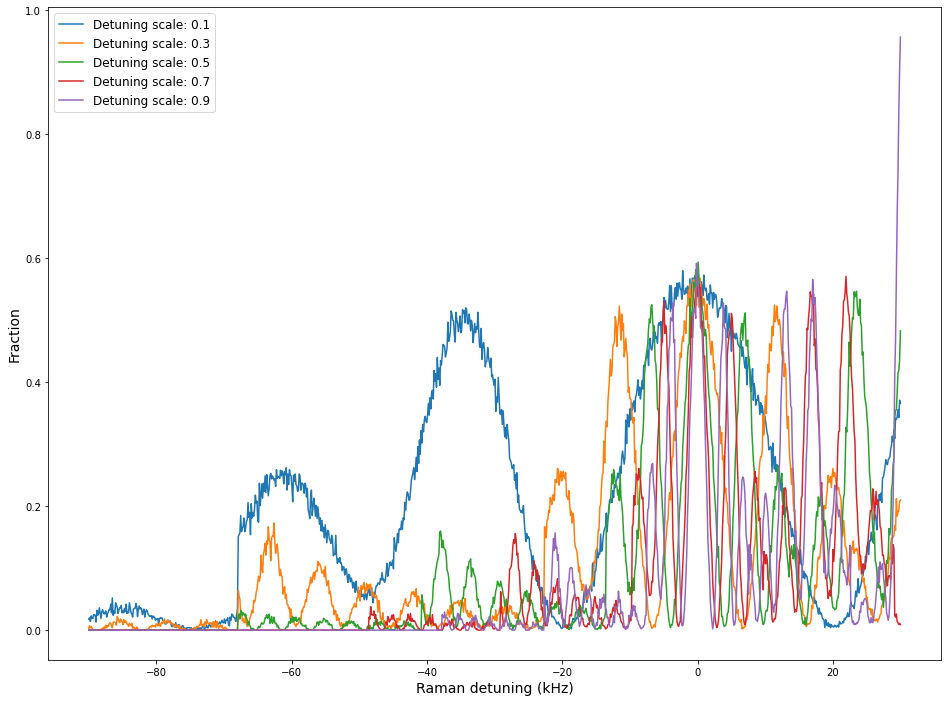

In [26]:
plt.figure(figsize=(16,12))
ind = np.arange(len(fractions))[1::2]
for i in ind:
    plt.plot(cp.asnumpy(frequencys*1e-3), pols[i]/1000, label=f"Detuning scale: {fractions[i]:.1f}")
plt.xlabel("Raman detuning (kHz)", fontsize=14)
plt.ylabel("Fraction", fontsize=14)
plt.legend(fontsize=12)